## 0.Imports

In [1]:
%matplotlib nbagg
#%matplotlib inline

#I/O
import os
import dm3_lib as dm3
import h5py
from sklearn.externals import joblib

#graphics
import matplotlib
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.gridspec as gridspec
import pylab as P


#processing 
import numpy as np
from scipy import fftpack
from scipy import ndimage

from skimage.feature import blob_log
from sklearn import cluster, mixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from collections import OrderedDict
from scipy.spatial import cKDTree

C:\Users\wyw\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import cv2
#neural networks
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Activation, Reshape
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


### Read the image data from the movie

In [3]:
path = './'
filename = '60kV-0126.dm3'

In [4]:
dm3f = dm3.DM3(path + filename)
imgdata = dm3f.imagedata

Rescale the image and normalize it

In [134]:
for t in dm3f.tags:
    if 'PMTDF' in t:
        scale = float(dm3f.tags[t])/64000
        
imgdata = imgdata/scale
imgdata = imgdata - np.amin(imgdata)
imgdata = imgdata/np.amax(imgdata)

In [6]:
directory = './Figures/' + filename[:-4] + '/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [7]:
#first frame of the movie
imgsrc = imgdata[0]

<IPython.core.display.Javascript object>


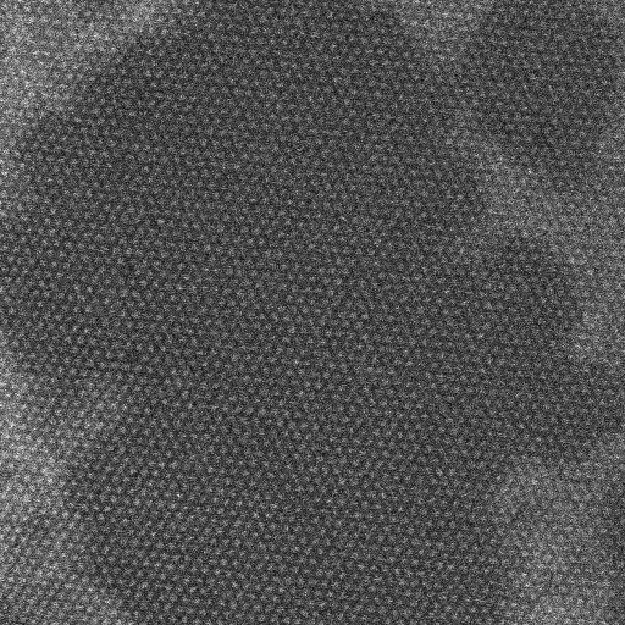

In [8]:
#plot real space image
fig100 = plt.figure(100, figsize=(5,5))
ax = fig100.add_axes([0, 0, 1, 1])
ax.imshow(imgsrc, cmap = 'gray')
ax.axis('off')

#save the figure
fig100.savefig(directory + filename + '_realspace.png')

In [12]:
# 1/ratio of the radius of the mask to the original image in pixels
maskratio = 10

In [13]:
def FFTmask(imgsrc, maskratio=10):
    """Takes a square real space image and filter out a disk with radius equal to:
    1/maskratio * image size.
    Retruns FFT transform of the image and the filtered FFT transform
    """
    # Take the fourier transform of the image.
    F1 = fftpack.fft2((imgsrc)) 
    # Now shift so that low spatial frequencies are in the center.
    F2 = (fftpack.fftshift((F1)))
    # copy the array and zero out the center
    F3 = F2.copy()
    l = int(imgsrc.shape[0]/maskratio)
    m = int(imgsrc.shape[0]/2)
    y,x = np.ogrid[1: 2*l + 1, 1:2*l + 1]
    mask = (x - l)*(x - l) + (y - l)*(y - l) <= l*l
    F3[m-l:m+l, m-l:m+l] = F3[m-l:m+l, m-l:m+l] * (1 - mask)
    
    return F2, F3

In [14]:
F2, F3 = FFTmask(imgsrc, maskratio)

In [15]:
def FFTsub(imgsrc, F3):
    """Takes real space image and filtred FFT.
    Reconstructs real space image and subtracts it from the original.
    Returns normalized image. 
    """
    reconstruction = np.real(fftpack.ifft2(fftpack.ifftshift(F3)))
    diff = np.abs(imgsrc - reconstruction)
    
    #normalization
    diff = diff - np.amin(diff)
    diff = diff/np.amax(diff)
    
    return diff

In [16]:
diff = FFTsub(imgsrc, F3)

In [17]:
def threshImg(diff, threshL=0.25, threshH=0.75):
    """Takes in difference image, low and high thresold values, and outputs a map of all defects.
    """
    
    threshIL = diff < threshL  
    threshIH = diff > threshH
    threshI = threshIL + threshIH
    
    return threshI

In [18]:
threshL = 0.25
threshH = 0.75
threshI = threshImg(diff, threshL, threshH)

In [19]:
labelIm = threshI.astype(int)

### Generate Training data

In [20]:
#Generate x, y positions for sliding windows
def GenerateXYPos(window_size, window_step, image_width):
    """Takes the window size, step, and total image width 
    and generates all xy pairs for sliding window"""   
    xpos_vec = np.arange(0,image_width-window_size,window_step)
    ypos_vec = np.arange(0,image_width-window_size,window_step)
        
    num_steps = len(xpos_vec)    
            
    xpos_mat = np.tile(xpos_vec, num_steps)
    ypos_mat = np.repeat(ypos_vec, num_steps)
    pos_mat = np.column_stack((xpos_mat, ypos_mat))
            
    return pos_mat

In [21]:
def MakeWindow(imgsrc, xpos, ypos, window_size):
    """returns window of given size taken at position on image"""
    imgsrc = imgsrc[xpos:xpos+window_size, ypos:ypos+window_size]
    return imgsrc

In [22]:
def imgen(raw_image, pos_mat, window_size):
    """Returns all windows from image for given positions array"""
    
    immat = np.zeros(shape = (len(pos_mat), window_size, window_size))
    
    for i in np.arange(0,len(pos_mat)):
        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1], window_size) 
        immat[i,:,:,] = img_window
    
    return immat

In [23]:
def image_preprocessing(image_data, norm=0):
    """Reshapes data and optionally normalizes it"""
    image_data = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)
    image_data = image_data.astype('float32')
    if norm != 0:
        image_data = (image_data - np.amin(image_data))/(np.amax(image_data) - np.amin(image_data))
    return image_data

In [24]:
def label_preprocessing(image_data, nb_classes):
    """Returns labels / ground truth for images"""
    
    label4D = np.empty((0, image_data.shape[1], image_data.shape[2], nb_classes))
    for idx in range(image_data.shape[0]):
        img = image_data[idx,:,:]
        n, m = img.shape
        img = np.array(OneHotEncoder(n_values=nb_classes).fit_transform(img.reshape(-1,1)).todense())
        img = img.reshape(n, m, nb_classes)
        label4D = np.append(label4D, [img], axis = 0)    
    return label4D

In [25]:
def label_preprocessing2(image_data):
    """we can simplify this in case of only two classes"""
    
    label1 = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)
    label2 = -label1 + 1
    label4D = np.concatenate((label2, label1), axis = 3)
    return label4D

In [26]:
window_size = 256
window_step = 8
pos_mat = GenerateXYPos(window_size, window_step, imgsrc.shape[0])
print("On image size: ", imgsrc.shape[0], ' by ',  imgsrc.shape[1], ' pixels: ', len(pos_mat), "patches will be generated")

On image size:  512  by  512  pixels:  1024 patches will be generated


In [27]:
immat = imgen(imgsrc, pos_mat, window_size)
labelmat = imgen(labelIm, pos_mat, window_size)


In [132]:
immat2 =  image_preprocessing(immat, 1)
labelmat2 =  label_preprocessing(labelmat, nb_classes = 2)

## Training the Neural Network model to localize the defects

In [181]:
def model_defect(input_img, nb_classes = 2):
    """Creates a Deep Learning model for defect identification"""
    
    x = Convolution2D(20, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Convolution2D(40, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
        
    x = Convolution2D(40, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Convolution2D(20, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Convolution2D(nb_classes, (3, 3), activation = 'linear', padding='same')(x)
    x = Convolution2D(nb_classes, (1, 1), activation = 'linear', padding='same')(x)

    output = Activation('softmax')(x)
    
    return Model(input_img, output)

In [133]:
nb_classes = 2
target_size = (256, 256)

X_train, X_test, y_train, y_test = train_test_split(immat2, labelmat2, test_size = 0.2, random_state = 42)

### Trained the model for 50 epochs and got the accuracy for 93.71%

In [183]:
input_img = Input(shape=(target_size[0], target_size[1], 1)) 

model = model_defect(input_img)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
callback_tb = TensorBoard(log_dir='/tmp/AtomGen', histogram_freq=0,
                          write_graph=True, write_images=False)

model.fit(X_train, y_train, epochs=50, batch_size=32, 
          validation_data=(X_test, y_test), shuffle=True, verbose = 1)

Train on 819 samples, validate on 205 samples
Epoch 1/50
819/819 [==============================] - 213s 261ms/step - loss: 0.5906 - acc: 0.7286 - val_loss: 0.5791 - val_acc: 0.7270
Epoch 2/50
819/819 [==============================] - 206s 251ms/step - loss: 0.5724 - acc: 0.7288 - val_loss: 0.5628 - val_acc: 0.7270
Epoch 3/50
819/819 [==============================] - 206s 252ms/step - loss: 0.5180 - acc: 0.7333 - val_loss: 0.4879 - val_acc: 0.8255
Epoch 4/50
819/819 [==============================] - 221s 270ms/step - loss: 0.4286 - acc: 0.8123 - val_loss: 0.3928 - val_acc: 0.8240
Epoch 5/50
819/819 [==============================] - 209s 255ms/step - loss: 0.3664 - acc: 0.8438 - val_loss: 0.3556 - val_acc: 0.8404
Epoch 6/50
819/819 [==============================] - 207s 253ms/step - loss: 0.3344 - acc: 0.8545 - val_loss: 0.3145 - val_acc: 0.8646
Epoch 7/50
819/819 [==============================] - 208s 254ms/step - loss: 0.3215 - acc: 0.8601 - val_loss: 0.3029 - val_acc: 0.8699
Ep

#### Saved the model and weights to the folder

In [184]:
model.save("./DefectModel50.h5")
model.save_weights("./DefectModel_weights50.h5")
print('Saved model and weights to disk.\n')

Saved model and weights to disk.



Reload the model

In [29]:
model50=load_model("DefectModel50.h5")

In [31]:
def splitImage(img, target_size):
    """Splits image into patches with given size"""
    
    xs = img.shape[0]
    ys = img.shape[1]
    nxp = int(xs/target_size[0])
    nyp = int(xs/target_size[1])
    
    impatchmat = np.zeros(shape=(int(nxp*nyp), target_size[0], target_size[1], 1))
    
    count = 0
    for i in range(nxp):
        for i2 in range(nyp):
            xstart = target_size[0] * i
            ystart = target_size[1] * i2
            xend = target_size[0] * (i + 1)
            yend = target_size[1] * (i2 + 1)

            impatchmat[count, :, :, 0] = img[xstart:xend, ystart:yend]
            count = count + 1
            
    return impatchmat

Apply the trained model to the rest of the movie to identify defects.

In [32]:
def predictDefects(img, model, target_size, nb_classes=2):
    """Uses given DL model to generate prediciton maps on the image"""
    
    xs = img.shape[0]
    ys = img.shape[1]
    nxp = int(xs/target_size[0])
    nyp = int(xs/target_size[1])
    classpred = np.zeros(shape=(nb_classes,xs, ys))

    impatchmat = splitImage(img, target_size)
    res = model.predict(impatchmat)
    
    count = 0
    for i in range(nxp):
        for i2 in range(nyp):
            xstart = target_size[0] * i
            ystart = target_size[1] * i2
            xend = target_size[0] * (i + 1)
            yend = target_size[1] * (i2 + 1)
            
            for i3 in range(nb_classes):
                classpred[i3, xstart:xend, ystart:yend] = res[count, :, :, i3]
                
            count = count + 1
            
    return classpred

In [201]:
#use frame number to get one specific frame in the movie
fnum =80
classpred = predictDefects(imgdata[fnum], model50, (256,256), nb_classes)

<IPython.core.display.Javascript object>


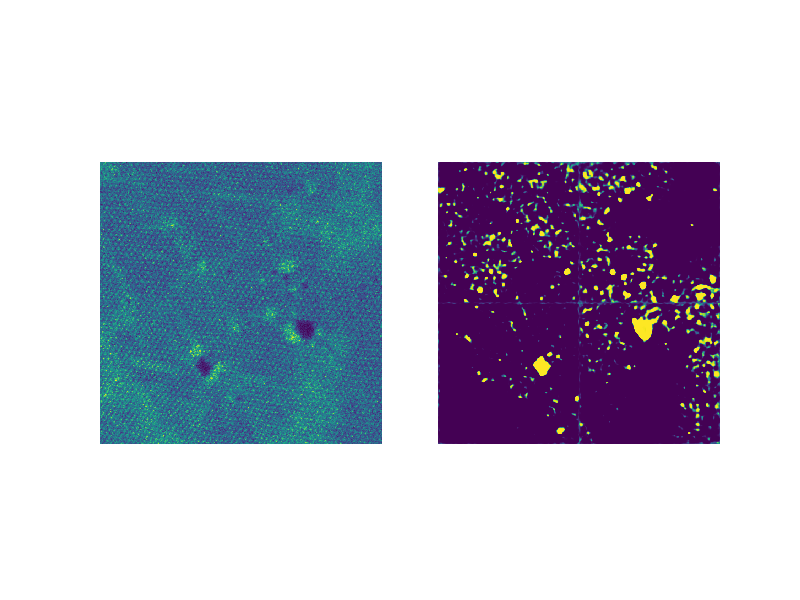

(-0.5, 511.5, 511.5, -0.5)

In [202]:
fig300 = plt.figure(300)
ax1 = fig300.add_subplot(121)
ax1.imshow(imgdata[fnum])
ax1.axis('off')
ax2 = fig300.add_subplot(122)
ax2.imshow(classpred[1])
ax2.axis('off')

<IPython.core.display.Javascript object>


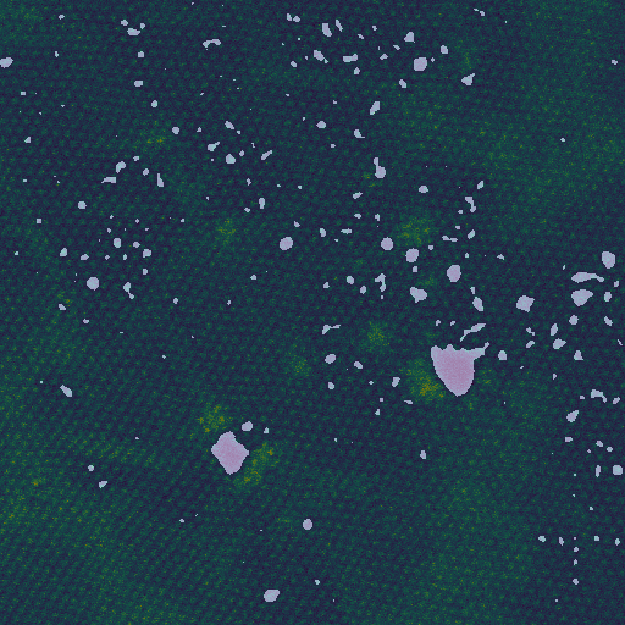

(-0.5, 511.5, 511.5, -0.5)

In [203]:
fig301 = plt.figure(301, figsize=(5,5))
ax = fig301.add_axes([0, 0, 1, 1])

ax.imshow(imgdata[fnum])
ax.imshow(classpred[1] > 0.97, cmap='hot', alpha=0.5)
ax.axis('off')

In [143]:
def extractDefects(img, classpred, softmax_threhold, bbox):
    
    defim = np.ndarray(shape=(0, bbox*2, bbox*2))
    defcoord = np.ndarray(shape=(0, 2))
    defcount = 0
    
    _, thresh = cv2.threshold(classpred[1], softmax_threhold, 1, cv2.THRESH_BINARY)
    
    s = [[1,1,1],[1,1,1],[1,1,1]]
    labeled, nr_objects = ndimage.label(thresh, structure=s) 
    loc = ndimage.find_objects(labeled)
    cc = ndimage.measurements.center_of_mass(labeled, labeled, range(nr_objects + 1))
    sizes = ndimage.sum(thresh,labeled,range(1, nr_objects +1)) 

    #filter found points
    cc2 = cc[1:]
    t = zip(cc2, sizes)
    ccc = [k[0] for k in t if (k[1] < 700 and k[1] > 5) ]

    max_coord = ccc
    
    
    for point in max_coord:
    
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2

        if startx > 0 and startx < img.shape[0] - bbox*2:
            if starty > 0 and starty < img.shape[1] - bbox*2: 

                defim.resize(defim.shape[0] + 1, bbox*2, bbox*2)
                defim[defcount] = img[startx:endx, starty:endy]
                defcoord.resize(defcoord.shape[0] + 1, 2)
                defcoord[defcount] = point[0:2]

                defcount = defcount + 1
            
    
    return thresh, defim, defcoord

In [204]:
thresh, defim, defcoord = extractDefects(imgdata[fnum], classpred, softmax_threhold = 0.99, bbox=32)

C:\Users\wyw\Miniconda3\lib\site-packages\scipy\ndimage\measurements.py:1301: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


<IPython.core.display.Javascript object>


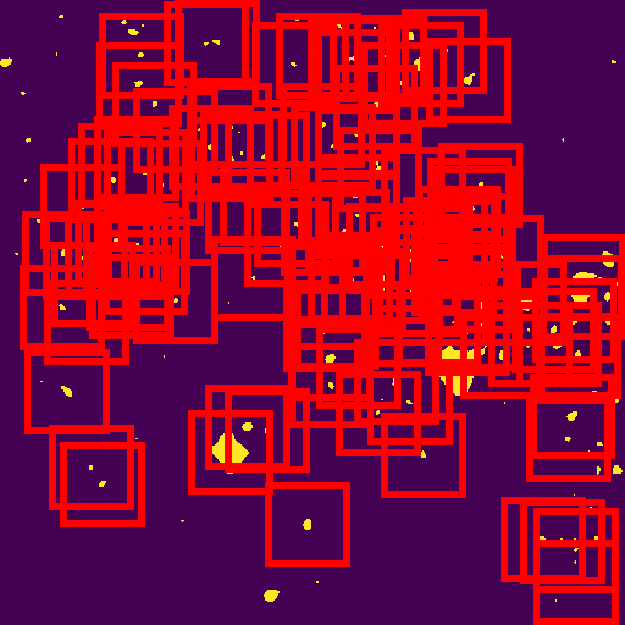

(-0.5, 511.5, 511.5, -0.5)

In [205]:
fig302 = plt.figure(302, figsize=(5,5))
ax = fig302.add_axes([0, 0, 1, 1])
ax.imshow(thresh)
bbox = 32

for point in defcoord:
    startx = int(round(point[0] - bbox))
    endx = startx + bbox*2
    starty = int(round( point[1] - bbox))
    endy = starty + bbox*2
    
    p = patches.Rectangle( (starty, startx), bbox*2, bbox*2,  fill=False, edgecolor='red', lw=4)
    ax.add_patch(p)
    
ax.axis('off')

In [206]:
bbox=32
def defectcropped(bbox, fnum, defcoord):
    defect_list=[]
    for point in defcoord:
        startx = int(round(point[0] - bbox))
        endx = startx + bbox*2
        starty = int(round( point[1] - bbox))
        endy = starty + bbox*2
        if startx<0 or startx>512:
            continue
        if endx<0 or endx>512:
            continue
        if starty<0 or starty>512:
            continue
        if endy<0 or endy>512:
            continue
        else:
            cropped=imgdata[fnum][startx:endx, starty:endy]
            defect_list.append(cropped)  
    return defect_list

In [207]:
defect_list=defectcropped(bbox, fnum, defcoord)
# convert list to array
defect_list=np.array(defect_list)
# reshape the array size to fit the required shape in model_defect_type 
defect_list=defect_list.reshape(defect_list.shape[0],64,64,1)

In [58]:
# reload the model to identify the defect type in each defect window of the frame.
model_defect_type=load_model("New_5_8_18_defect_CNN.h5")

In [192]:
#The probabilities for all type of defects in one defect window
model_defect_type.predict(np.array([defect_list[20]]))

array([[6.4491667e-02, 8.7988630e-02, 1.5566272e-04, 1.9640514e-01,
        6.3533896e-01, 1.5619911e-02]], dtype=float32)

Save all the ``defect_list`` per frame in movie to the folder "defect_list"

In [208]:
#save all the defect_lists per frame in movie to the folder "defect_list"
directory = './defect_list/' 
if not os.path.exists(directory):
    os.makedirs(directory)
for i in range(len(imgdata)):
    fnum = i
    classpred = predictDefects(imgdata[fnum], model50, (256,256), nb_classes)
    thresh, defim, defcoord = extractDefects(imgdata[fnum], classpred, softmax_threhold = 0.99, bbox=32)
    defect_list=defectcropped(bbox, fnum, defcoord)
    np.save("./defect_list/defect_list" +str(fnum) , defect_list)

C:\Users\wyw\Miniconda3\lib\site-packages\scipy\ndimage\measurements.py:1301: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]
